In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, ELU
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers.core import Lambda

from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Generator

In [331]:
import os
import csv

reduced = False

if reduced == True:
    csv_filepath = 'data-udacity/driving_log_reduced.csv'
else:
    csv_filepath = 'data-udacity/driving_log.csv'
samples = []
with open(csv_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
"""
csv_filepath = 'data-udacity/driving_log_18_bridge_reduced2.csv'

with open(csv_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
"""
csv_filepath = 'data-udacity-flipped/driving_csv_flipped.csv'

with open(csv_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

samples = samples[1:]
print("Samples: ", len(samples))    
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.1)

Samples:  16073


In [332]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './data-udacity/'+batch_sample[0]
                # name = './data-udacity/IMG/'+batch_sample[0].split('/')[-1]
                center_image = mpimg.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            
            # print("X_train: ", X_train)
            # print("y_train: ", y_train)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### Augment data (Flip images)

In [316]:
flipped_csv = driving_csv

In [324]:
flipped_csv['steering'] = flipped_csv['steering'] * -1.0

In [326]:
flipped_csv.to_csv("data-udacity-flipped/driving_csv_flipped.csv")

In [321]:
flipped_csv_five = flipped_csv[100:105]
flipped_csv_five

,center,left,right,steering,throttle,brake,speed
100,IMG/center_2016_12_01_13_32_48_402.jpg,IMG/left_2016_12_01_13_32_48_402.jpg,IMG/right_2016_12_01_13_32_48_402.jpg,-0.059757,0.985533,0.0,30.18687
101,IMG/center_2016_12_01_13_32_48_503.jpg,IMG/left_2016_12_01_13_32_48_503.jpg,IMG/right_2016_12_01_13_32_48_503.jpg,-0.059757,0.985533,0.0,30.18692
102,IMG/center_2016_12_01_13_32_48_604.jpg,IMG/left_2016_12_01_13_32_48_604.jpg,IMG/right_2016_12_01_13_32_48_604.jpg,-0.059757,0.985533,0.0,30.18694
103,IMG/center_2016_12_01_13_32_48_705.jpg,IMG/left_2016_12_01_13_32_48_705.jpg,IMG/right_2016_12_01_13_32_48_705.jpg,-0.059757,0.985533,0.0,30.18695
104,IMG/center_2016_12_01_13_32_48_805.jpg,IMG/left_2016_12_01_13_32_48_805.jpg,IMG/right_2016_12_01_13_32_48_805.jpg,-0.059757,0.985533,0.0,30.18692


In [322]:
flipped_csv_five['steering'] = flipped_csv_five['steering'] * -1.0

/Users/jessica/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [323]:
flipped_csv_five

,center,left,right,steering,throttle,brake,speed
100,IMG/center_2016_12_01_13_32_48_402.jpg,IMG/left_2016_12_01_13_32_48_402.jpg,IMG/right_2016_12_01_13_32_48_402.jpg,0.059757,0.985533,0.0,30.18687
101,IMG/center_2016_12_01_13_32_48_503.jpg,IMG/left_2016_12_01_13_32_48_503.jpg,IMG/right_2016_12_01_13_32_48_503.jpg,0.059757,0.985533,0.0,30.18692
102,IMG/center_2016_12_01_13_32_48_604.jpg,IMG/left_2016_12_01_13_32_48_604.jpg,IMG/right_2016_12_01_13_32_48_604.jpg,0.059757,0.985533,0.0,30.18694
103,IMG/center_2016_12_01_13_32_48_705.jpg,IMG/left_2016_12_01_13_32_48_705.jpg,IMG/right_2016_12_01_13_32_48_705.jpg,0.059757,0.985533,0.0,30.18695
104,IMG/center_2016_12_01_13_32_48_805.jpg,IMG/left_2016_12_01_13_32_48_805.jpg,IMG/right_2016_12_01_13_32_48_805.jpg,0.059757,0.985533,0.0,30.18692


In [ ]:
for row in original_csv:
    row_steering * - 1.0

### Augmented data (taken from simulator)

['IMG/center_2016_12_01_13_32_47_394.jpg', ' IMG/left_2016_12_01_13_32_47_394.jpg', ' IMG/right_2016_12_01_13_32_47_394.jpg', ' 0.3583844', ' 0.9855326', ' 0', ' 30.0653']


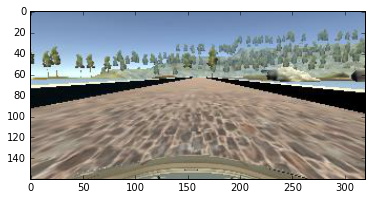

In [251]:
index = 90
plt.imshow(mpimg.imread('data-udacity/' + samples[index][0]))
print(samples[index])

In [263]:
# Read in augmented data
augmented_filepath = 'data-augmented/driving_log.csv'

augmented_samples = []
with open(csv_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        augmented_samples.append(line)

In [261]:
augmented = pd.read_csv('data-augmented/driving_log.csv')

In [284]:
augmented.iloc[80:]['steering']

80    -0.948375
81    -1.000000
82    -1.000000
83    -1.000000
84    -0.095329
85     0.000000
86     0.000000
87     0.000000
88     0.000000
89     0.000000
90     0.000000
91     0.000000
92    -0.999966
93    -1.000000
94    -0.646306
95    -0.339898
96     0.000000
97    -0.134130
98    -0.438201
99    -0.795810
100   -0.489519
101   -0.184875
102    0.000000
103    0.000000
104    0.000000
105    0.000000
106    0.000000
107    0.000000
108    0.000000
109    0.000000
         ...   
199    0.000000
200    0.000000
201    0.000000
202    0.000000
203    0.000000
204    0.000000
205    0.118800
206    0.000000
207    0.000000
208    0.000000
209    0.000000
210    0.000000
211    0.000000
212    0.121641
213    0.000000
214    0.000000
215    0.000000
216    0.000000
217    0.000000
218    0.290463
219    0.432519
220    0.132534
221    0.000000
222    0.000000
223   -0.117999
224   -0.167568
225    0.000000
226    0.000000
227    0.000000
228    0.000000
Name: steering, dtype: f

0.1187999


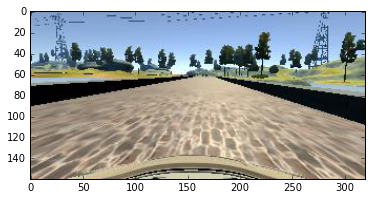

In [282]:
index = 205
plt.imshow(X_images[index])
print(y[index])

In [265]:
len(augmented)

229

Images: 229
Sample image
Image shape:  (160, 320, 3)


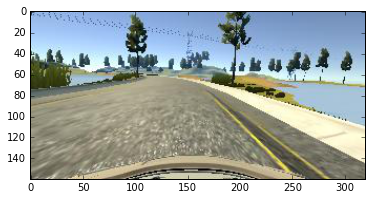

In [267]:
X_path = [augmented.iloc[i]["center"] \
              for i in range(len(augmented))]
y = [augmented.iloc[i]["steering"] \
              for i in range(len(augmented))]

# Import images
X_images = [mpimg.imread(image_path) for image_path in X_path]

# View image
print("Images: %d" % len(X_images))
print("Sample image")
plt.imshow(X_images[0])
# X_images[0]

imshape = X_images[0].shape
print("Image shape: ", imshape)

### Models

In [303]:
def resize(image):
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, 66, 200)

def resize_comma(image):
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, 40, 160)

def resize_comma_10_40(image):
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, 40, 160)

def halve_size(image):
    imshape = image.shape
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, imshape[0] // 2, imshape[1] // 2)

def resize_80_160(image):
    imshape = image.shape
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, 80, 160)

In [199]:
# NVIDIA End to End Learning Pipeline Model

model = Sequential()

# Crop the images
model.add(Cropping2D(cropping=((60, 20), (0, 0)),
                     dim_ordering='tf', # default
                     input_shape=(160, 320, 3)))

# Resize the data
model.add(Lambda(resize))

model.add(Lambda(lambda x: x[:,:,:,0:1]))

# Normalise data
# TODO: some people use /255.0 - 0.5. Why?
model.add(Lambda(lambda x: x/127.5 - 1.))


# Conv layer 1, 5x5 kernel to 24@ (from 3@)
# TODO: What does the number of filters MEAN?
# Stride of 2x2
model.add(Convolution2D(24, 36, 104,
                        input_shape=(66,200))
         )

model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 2, 5x5 kernel to 36@
model.add(Convolution2D(36, 18, 50))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 3, 5x5 kernel to 48@
model.add(Convolution2D(48, 10, 32))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 4, 3x3 kernel to 64@
model.add(Convolution2D(64, 3, 12))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Conv layer 5, 3x3 kernel to 64@
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
model.add(SpatialDropout2D(0.1))

# Flatten
model.add(Flatten())

# Removed: fully connected layer 1, 1164 neurons

# Fc2, 100 neurons
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Fc3, 50 neurons
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Fc4, 10 neurons
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Output
model.add(Dense(1, activation="tanh"))

# Compile model
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001)
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_65 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_65[0][0]        
____________________________________________________________________________________________________
lambda_153 (Lambda)              (None, 66, 200, 3)    0           cropping2d_65[0][0]              
____________________________________________________________________________________________________
lambda_154 (Lambda)              (None, 66, 200, 1)    0           lambda_153[0][0]                 
____________________________________________________________________________________________________
lambda_155 (Lambda)              (None, 66, 200, 1)    0           lambda_154[0][0]                 
___________________________________________________________________________________________

In [312]:
# Comma.ai model
# https://github.com/commaai/research/blob/master/train_steering_model.py

model = Sequential()

# Crop 50 pixels from the top of the image and 20 from the bottom
model.add(Cropping2D(cropping=((50, 20), (0, 0)),
                     dim_ordering='tf', # default
                     input_shape=(160, 320, 3)))

# Resize the data
model.add(Lambda(resize_comma))

model.add(Lambda(lambda x: x[:,:,:,0:1]))

model.add(Lambda(lambda x: (x/255.0) - 0.5))

model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())

model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())

model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))

model.add(Flatten())
# model.add(Dropout(.2))
model.add(ELU())

model.add(Dense(512))
# model.add(Dropout(.5))
model.add(ELU())

model.add(Dense(1))

adam = Adam(lr=0.0001)

model.compile(optimizer=adam, loss="mse", metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_90 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_90[0][0]        
____________________________________________________________________________________________________
lambda_219 (Lambda)              (None, 40, 160, 3)    0           cropping2d_90[0][0]              
____________________________________________________________________________________________________
lambda_220 (Lambda)              (None, 40, 160, 1)    0           lambda_219[0][0]                 
____________________________________________________________________________________________________
lambda_221 (Lambda)              (None, 40, 160, 1)    0           lambda_220[0][0]                 
___________________________________________________________________________________________

In [305]:
# konstmsu

model = Sequential()

# Crop the images
model.add(Cropping2D(cropping=((50, 20), (0, 0)),
                     dim_ordering='tf', # default
                     input_shape=(160, 320, 3)))

# Resize the data
model.add(Lambda(resize))

model.add(Lambda(rgb_to_hsv))

# model.add(Lambda(lambda x: x[:,:,:,0:1]))

# Normalise data
# TODO: some people use /255.0 - 0.5. Why?
model.add(Lambda(lambda x: x/127.5 - 1.))

model.add(Convolution2D(5, 5, 5, subsample=(2, 2), activation='relu'))
# model.add(Dropout(0.1))

model.add(Convolution2D(7, 5, 5, subsample=(2, 2), activation='relu'))
# model.add(Dropout(0.1))

model.add(Convolution2D(8, 5, 5, subsample=(2, 2), activation='relu'))
# model.add(Dropout(0.1))

model.add(Convolution2D(12, 3, 5, subsample=(1, 1), activation='relu'))
# model.add(Dropout(0.1))
model.add(Convolution2D(12, 3, 3, subsample=(1, 1), activation='relu'))
# model.add(Dropout(0.1))
# model.add(Convolution2D(12, 3, 3, subsample=(1, 1), activation='relu'))

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='tanh'))

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss="mse")

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_87 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_87[0][0]        
____________________________________________________________________________________________________
lambda_210 (Lambda)              (None, 66, 200, 3)    0           cropping2d_87[0][0]              
____________________________________________________________________________________________________
lambda_211 (Lambda)              (None, 66, 200, 3)    0           lambda_210[0][0]                 
____________________________________________________________________________________________________
lambda_212 (Lambda)              (None, 66, 200, 3)    0           lambda_211[0][0]                 
___________________________________________________________________________________________

Data preprocessing reference: [Geoff Breemer](https://carnd-forums.udacity.com/questions/36045049/answers/36047341)

### Train model

In [328]:
# Train model
batch_size = 32
nb_epoch = 20
# data_augmentation = True
 
checkpointer = ModelCheckpoint(filepath="./tmp/comma-v2e.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=False)
    
model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), nb_epoch=nb_epoch,
                    callbacks=[checkpointer])

Epoch 1/20
 544/7634 [=>............................] - ETA: 33s - loss: 0.0080 - acc: 0.5294

KeyboardInterrupt: 

In [314]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model-comma-v2e.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
